<a href="https://colab.research.google.com/github/MoritzHaw/BPI2019_Colabatory/blob/main/IVaGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py

In [55]:
import pm4py
import numpy as np
import pandas as pd

In [56]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('/content/CSV_IVaGR_filtered', encoding='cp1252',sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

In [ ]:
log_csv

In [58]:
def to_eventlog(dataset):
  # Convert log_csv to event_log
  parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}  # identify the case_id_key name (if not change it will simply be the nane of the coloumn)
  event_log = log_converter.apply(dataset, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
  return event_log

In [59]:
from pm4py.statistics.traces.generic.pandas import case_statistics  # filter variants

def filter_by_variants(dataset):
        variants = case_statistics.get_variants_df(dataset, parameters={
            case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
            case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})
        return variants


# Miner & Graphen

In [60]:
def direct_follow_graph(e_log):

  # visualize as direct follow graph

    from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
    dfg = dfg_discovery.apply(e_log)

    # Filter direct followed graph
    dfg, sa, ea = pm4py.discover_directly_follows_graph(e_log)
    activities_count = pm4py.get_event_attribute_values(e_log, "concept:name")

    # filter activites - only top 10 percent

    from pm4py.algo.filtering.dfg import dfg_filtering
    dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(dfg, sa, ea, activities_count, 0.2)

    # filter paths - only 10 percent

    dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_paths_percentage(dfg, sa, ea, activities_count, 0.1)
                                        
                                        

    from pm4py.visualization.dfg import visualizer as dfg_visualization
    gviz = dfg_visualization.apply(dfg, log=e_log, variant=dfg_visualization.Variants.FREQUENCY)
    dfg_visualization.view(gviz)

In [61]:
# Heuristic miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer


def heuristic_miner(e_log):

    heu_net = heuristics_miner.apply_heu(event_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1000,
                                                              heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1000})
    plt.figure(figsize=(5,5))
                        
    gviz = hn_visualizer.apply(heu_net)
    hn_visualizer.view(gviz)

In [62]:
# petri net from heuristic miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer


  # Visualise a Petri Net
def visualize_petri_heu(e_log, net, im, fm):
    gviz = pn_visualizer.apply(net, im, fm, log=e_log, variant=pn_visualizer.Variants.FREQUENCY)
    pn_visualizer.view(gviz)

def petri_from_heu(e_log, tresh: float, min_act_count, min_dfg_occurences):

    parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: tresh, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: min_act_count, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: min_dfg_occurences} 
    net, im, fm = heuristics_miner.apply(e_log, parameters=parameters)

    return net, im, fm      

In [63]:
# process tree from inductive miner

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

def visualize_pt(tree):
    gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
    pt_visualizer.view(gviz)
 
def pt_from_inductive_im(e_log): # Produces a model with perfect replay fitness.

    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IM)
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IM)  
          

    #visualize_pt(tree)    
  
    return net, im, fm, tree

def pt_from_inductive_imf(e_log, tresh): # Produces a more precise model, without fitness guarantees, by eliminating some behavior.
    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf.value.Parameters.NOISE_THRESHOLD: tresh})
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IMf,
                                          parameters={inductive_miner.Variants.IMf.value.Parameters.NOISE_THRESHOLD: tresh})  #The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2
          
 
    #visualize_pt(tree) 
  
    return net, im, fm, tree  


def pt_from_inductive_imd(e_log, tresh): # A variant of inductive miner that considers only the directly-follows graph, for maximum performance. However, replay fitness guarantees are lost.
    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IMd, parameters={inductive_miner.Variants.IMd.value.Parameters.NOISE_THRESHOLD: tresh})
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IMd,
                                          parameters={inductive_miner.Variants.IMd.value.Parameters.NOISE_THRESHOLD: tresh})  #The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2
          

    #visualize_pt(tree) 
  
    return net, im, fm, tree  


In [64]:
# Convert process tree into a Petri Net
from pm4py.objects.conversion.process_tree import converter as pt_converter

def petri_from_pt(tree, e_log):
  
  net, im, fm = pt_converter.apply(tree)
  ## Visualise
  gviz = pn_visualizer.apply(net, im, fm, 
                            variant=pn_visualizer.Variants.FREQUENCY, 
                            log=e_log)
  pn_visualizer.view(gviz)

  return net, im, fm

In [65]:

from pm4py.objects.conversion.wf_net import converter as wf_net_converter

def pt_from_alpha(e_log):
  net, im, fm = pm4py.discover_petri_net_alpha(log)
  

  tree = wf_net_converter.apply(net, im, fm)
  print(tree)

# BPMN

In [66]:
#bpmn

from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.bpmn.layout import layouter


def to_bpmn(pt_tree, name: str):

  bpmn = converter.apply(pt_tree, variant=converter.Variants.TO_BPMN)
  bpmn = layouter.apply(bpmn, variant=layouter.Variants.GRAPHVIZ)
  #pm4py.visualization.bpmn.visualizer.matplotlib_view(bpmn)
  pm4py.write_bpmn(bpmn, name, enable_layout=True)

# Testing

In [67]:
def calculate_score(fitness, prec, gen, simp):
    fit_sum = fitness.get('perc_fit_traces') + (fitness.get('average_trace_fitness')*100) + (fitness.get('log_fitness')*100) + fitness.get('percentage_of_fitting_traces')
    fit = (fit_sum/4)/100
    score = (fit + prec + gen + simp)/4
    return score

In [68]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

def test(e_log, net, im, fm):
        fitness = replay_fitness_evaluator.apply(e_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
        print('Fitness: ', fitness)
        
        #perc_fit_traces': 87.56476683937824, 'average_trace_fitness': 0.9990753857628418, 'log_fitness': 0.9983287356471942, 'percentage_of_fitting_traces'
        prec = precision_evaluator.apply(e_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        print('Precision: ', prec)

        gen = generalization_evaluator.apply(e_log, net, im, fm)
        print('Generalization: ', gen)

        simp = simplicity_evaluator.apply(net)
        print('Simplicity: ', simp)

        score = calculate_score(fitness, prec, gen, simp)
        return score

In [69]:
def get_best_petri(e_log):

   highest_score = []
   min_dfg_occurences = [0, 300, 600]
   min_act_count = [0,300, 600]
   dependency_tresh = [0.0, 0.5, 0.99]
   score = 0
   
   for k in dependency_tresh:
    for j in min_act_count:
     for i in min_dfg_occurences:
          net, im, fm = petri_from_heu(e_log, k, j, i)
          calc_score = test(e_log, net, im, fm)
          if calc_score > score:
            score = calc_score
            highest_score.clear()
            highest_score.append([k, j, i, score])

   print(highest_score)
   return highest_score

In [70]:
def get_best_pt_from_inductive(e_log):
   
   
   dependency_tresh = [0.0, 0.19,  0.39,  0.59,  0.79, 0.99]
   

   def test_im():
      score = 0
      highest_score = []
      net, im, fm, tree = pt_from_inductive_im(e_log)
      calc_score = test(e_log, net, im, fm)
      highest_score.append([calc_score])
      return highest_score

   def test_imf():
      score = 0
      highest_score = []
      for k in dependency_tresh:
              net, im, fm, tree = pt_from_inductive_imf(e_log, k)
              calc_score = test(e_log, net, im, fm)
              if calc_score > score:
                score = calc_score
                highest_score.clear()
                highest_score.append([k, score])
      return highest_score

   def test_imd():
      score = 0
      highest_score = []
      for k in dependency_tresh:
              net, im, fm, tree = pt_from_inductive_imd(e_log, k)
              calc_score = test(e_log, net, im, fm)
              if calc_score > score:
                score = calc_score
                highest_score.clear()
                highest_score.append([k, score])
      return highest_score

   im_score = test_im()
   imf_score = test_imf()
   imd_score = test_imd()

   print('im_score: ', im_score)
   print('imf_score: ', imf_score)
   print('imd_score: ', imd_score)
   return im_score, imf_score, imd_score

# Filter Mehtods to improve visibility

In [71]:
# filter between EC Purchase Orders(SRM) and without SRM

from pm4py.algo.filtering.pandas.attributes import attributes_filter

def filter_log_by_x(dataset, doc_type: str, attr_key: str, pos_neg: bool):

    df_traces = attributes_filter.apply(
        dataset, [doc_type], parameters={attributes_filter.Parameters.CASE_ID_KEY:
                                         "case:concept:name", 
                                         attributes_filter.Parameters.ATTRIBUTE_KEY: 
                                         attr_key, 
                                         attributes_filter.Parameters.POSITIVE: 
                                         pos_neg})
   
    return df_traces


def filter_eventlog_by_docType(e_log, doc_type: str,  attr_key: str, pos_neg: bool):
   
  
    tracefilter_pos = attributes_filter.apply(e_log, doc_type[0],
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: attr_key[0], attributes_filter.Parameters.POSITIVE: pos_neg})
    
    #tracefilter_neg = attributes_filter.apply(e_log, [doc_type],parameters={
    #                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "case:doc:type", attributes_filter.Parameters.POSITIVE: False})
    
    return tracefilter_pos# tracefilter_neg

# Bar Chart to compare Pareto

In [72]:
def count_events(dataset):
  return dataset['case:concept:name'].count()

In [73]:
# compare before and after filtering Pareto 

import matplotlib.pyplot as plt
import seaborn as sns

def comp_bef_aft(dataset1 , dataset2):

    plt.style.use('ggplot')

    x = ['without filtering', 'after filtering']
    events = [count_events(dataset1), count_events(dataset2)]

    x_pos = [i for i, _ in enumerate(x)]
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    color = sns.color_palette("muted")
    plt.figure(1, figsize=(5, 5))  # size
    plt.bar(x_pos, events, color=color)
    plt.xlabel("Filter")
 
    plt.ylabel("Events")
    #plt.title("Energy output from various fuel sources")
    plt.grid(False)

    plt.xticks(x_pos, x)
    plt.axhline(y=0, color='black')

    plt.show()

In [74]:
# compare before and after filtering date 

import matplotlib.pyplot as plt
import seaborn as sns

def comp_value_in_data(dataset1):

    data = dict(dataset1)

    plt.style.use('ggplot')

    x = list(data.keys())
    events = list(dataset1)

    x_pos = [i for i, _ in enumerate(x)]
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    color = sns.color_palette("muted")
    plt.figure(1, figsize=(5, 5))  # size
    plt.bar(x_pos, events, color=color)
    
 
    plt.ylabel("Events")
    #plt.title("Energy output from various fuel sources")
    plt.grid(False)

    plt.xticks(x_pos, x, rotation='vertical')
    plt.axhline(y=0, color='black')

    plt.show()

In [75]:
# Pareto principle
from pm4py.algo.filtering.log.variants import variants_filter

def filter_pareto(e_log):
   filtered_log = variants_filter.filter_log_variants_percentage(e_log, percentage=0.2)
   df_filtered = log_converter.apply(filtered_log, variant=log_converter.Variants.TO_DATA_FRAME)
   return df_filtered, filtered_log


In [76]:
from pm4py.algo.filtering.log.variants import variants_filter

def filter_log_frequency(e_log, dataset):
   filtered_log = variants_filter.filter_log_variants_percentage(
       e_log, percentage=calc_percentage_varfilter(dataset))
   return filtered_log

In [77]:
# 5 most frequent variant 

def calc_percentage_varfilter(dataset):
  share_of_frequent = 0
  for i in range(0,4): 
    share_of_frequent = (dataset['variant'].value_counts()[i]/
                         dataset['variant'].count()) + share_of_frequent
  #if share_of_frequent < 0.5:
    #share_of_frequent = share_of_frequent + (0.5-share_of_frequent)
  
  print(share_of_frequent)
  return share_of_frequent


In [78]:
# calculate overall share of batch vs user

def calc_share_batch_user(dataset):
  batch_share = dataset[dataset['event:user'].str.contains('batch')]['event:user'].count()/dataset['event:user'].count()
  user_share = dataset[dataset['event:user'].str.contains('user')]['event:user'].count()/dataset['event:user'].count()
  none_share = dataset[dataset['event:user'].str.contains('NONE')]['event:user'].count()/dataset['event:user'].count()
  print('batch: ', batch_share, 'user: ', user_share, 'none: ', none_share)
  return batch_share, user_share, none_share


# MAIN

In [79]:
event_log = to_eventlog(log_csv)

In [80]:
#log_csv.count()

In [81]:
#log, event_log = filter_pareto(event_log)


In [82]:
#log[log['variant'].str.contains('SRM')]

1. Filter SRM --> case:doc:type


In [83]:
log_SRM = filter_log_by_x(log_csv, "EC Purchase order", "case:doc:type", True)
log_noSRM = filter_log_by_x(log_csv, "EC Purchase order", "case:doc:type", False)
event_log_SRM = to_eventlog(log_SRM)
event_log_noSRM = to_eventlog(log_noSRM)

# Case statistics

In [84]:
log_SRM['case:concept:name'].nunique() # 386
log_noSRM['case:concept:name'].nunique() # 7534

7534

In [85]:
log_nunique = pd.DataFrame(log_csv.nunique().sort_values(ascending=False))
#log_nunique.to_excel('/content/excel/log_nunique.xlsx')
#log_nunique

In [86]:
# 2.3.1

log_csv[log_csv['variant'].str.contains('SRM')].value_counts('case:doc:type') 
#log_csv.value_counts('case:doc:type')




case:doc:type
EC Purchase order    6349
dtype: int64

# SRM

1. Filter by 5 most frequent variants

In [87]:
filtered_log_SRM = filter_log_frequency(event_log_SRM, log_SRM)

0.06363206804221136


In [88]:
log_SRM['variant'].count()

6349

In [ ]:
log_SRM['variant'].value_counts().to_frame()

In [90]:
score_inductive_SRM = get_best_pt_from_inductive(filtered_log_SRM) 
#im_score:  [[0.7322005540500212]]
#imf_score:  [[0.0, 0.7322005540500212]]
#imd_score:  [[0.0, 0.643685696141229]]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.4397905759162304


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7747259259981399
Simplicity:  0.7142857142857143


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.4397905759162304


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7747259259981399
Simplicity:  0.7142857142857143


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 85.71428571428571, 'average_trace_fitness': 0.9924812030075189, 'log_fitness': 0.9928057553956835, 'percentage_of_fitting_traces': 85.71428571428571}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.4397905759162304


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7943492064265785
Simplicity:  0.7391304347826086


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 85.71428571428571, 'average_trace_fitness': 0.9924812030075189, 'log_fitness': 0.9928057553956835, 'percentage_of_fitting_traces': 85.71428571428571}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.4397905759162304


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7943492064265785
Simplicity:  0.7391304347826086


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 50.0, 'average_trace_fitness': 0.8905597326649964, 'log_fitness': 0.8901515151515151, 'percentage_of_fitting_traces': 50.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.5190839694656488


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7943492064265785
Simplicity:  0.7674418604651162


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8423076923076925, 'log_fitness': 0.8430379746835444, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.5056179775280899


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7924610230197562
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8177097922502338, 'log_fitness': 0.820855614973262, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.7863247863247863


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.79472592599814
Simplicity:  0.8888888888888888


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.21705426356589153


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7326885209990242
Simplicity:  0.625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.21705426356589153


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7326885209990242
Simplicity:  0.625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9374884044526898, 'log_fitness': 0.9380297448183893, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.25779967159277506


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.6091937492284516
Simplicity:  0.6623376623376623


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9081958128078819, 'log_fitness': 0.8975265017667844, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.2904929577464789


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.6788044834908263
Simplicity:  0.6615384615384615


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9081958128078819, 'log_fitness': 0.8975265017667844, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.2904929577464789


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.6788044834908263
Simplicity:  0.6615384615384615


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9081958128078819, 'log_fitness': 0.8975265017667844, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.2904929577464789


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.6788044834908263
Simplicity:  0.6615384615384615
im_score:  [[0.7322005540500212]]
imf_score:  [[0.0, 0.7322005540500212]]
imd_score:  [[0.0, 0.643685696141229]]


In [ ]:
log_SRM[(log_SRM['concept:name'].str.contains('SRM') == False)].value_counts('event:user')


In [92]:
# calculation of users doing processes without SRM in SRM 
y = log_SRM[(log_SRM['concept:name'].str.contains('SRM')==False) & (log_SRM['event:user'].str.contains('user'))]['event:user'].count()/log_SRM[(log_SRM['concept:name'].str.contains('SRM')== False)]['event:user'].count()
print(y)

0.6572368421052631


In [93]:
# calculate share of batch SRM 
x = log_SRM[(log_SRM['concept:name'].str.contains('SRM')) & (log_SRM['event:user'].str.contains('batch'))]['event:user'].count()/log_SRM[(log_SRM['concept:name'].str.contains('SRM'))]['event:user'].count()
print(x)

0.8788153520701119


In [94]:
calc_share_batch_user(log_SRM)

batch:  0.46731768782485433 user:  0.3778547802803591 none:  0.15482753189478657


(0.46731768782485433, 0.3778547802803591, 0.15482753189478657)

In [95]:
log_SRM['case:concept:name'].count()

6349

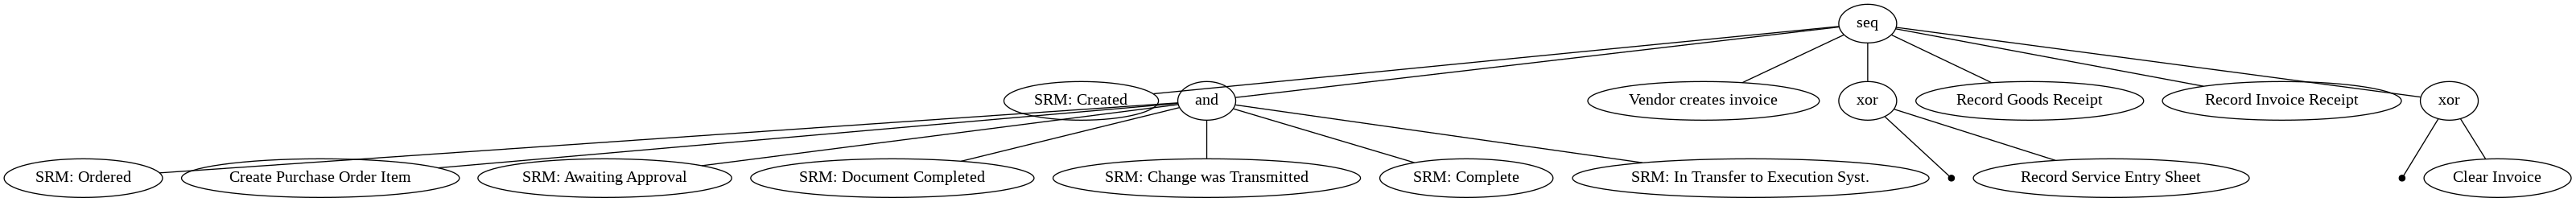

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.4397905759162304


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7747259259981399
Simplicity:  0.7142857142857143


In [96]:
net, im, fm, tree = pt_from_inductive_im(filtered_log_SRM)
visualize_pt(tree)
test(filtered_log_SRM, net, im, fm)
to_bpmn(tree, "filtered_log_SRM.bpmn")

In [97]:
score_petri_SRM = get_best_petri(filtered_log_SRM) # [[0.5, 0, 0, 0.737180314505272]]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 64.28571428571429, 'average_trace_fitness': 0.923015258735073, 'log_fitness': 0.9199006374203225, 'percentage_of_fitting_traces': 64.28571428571429}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.6967741935483871


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.710386220925515
Simplicity:  0.6949152542372882


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 64.28571428571429, 'average_trace_fitness': 0.9277864992150703, 'log_fitness': 0.9258586020486966, 'percentage_of_fitting_traces': 64.28571428571429}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.6344086021505376


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7516950313482589
Simplicity:  0.7777777777777779


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.285714285714286, 'average_trace_fitness': 0.8571428571428569, 'log_fitness': 0.85, 'percentage_of_fitting_traces': 14.285714285714286}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.1025390625


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7953159061698531
Simplicity:  1.0
[[0.5, 0, 0, 0.737180314505272]]


replaying log with TBR, completed variants ::   0%|          | 0/929 [00:00<?, ?it/s]

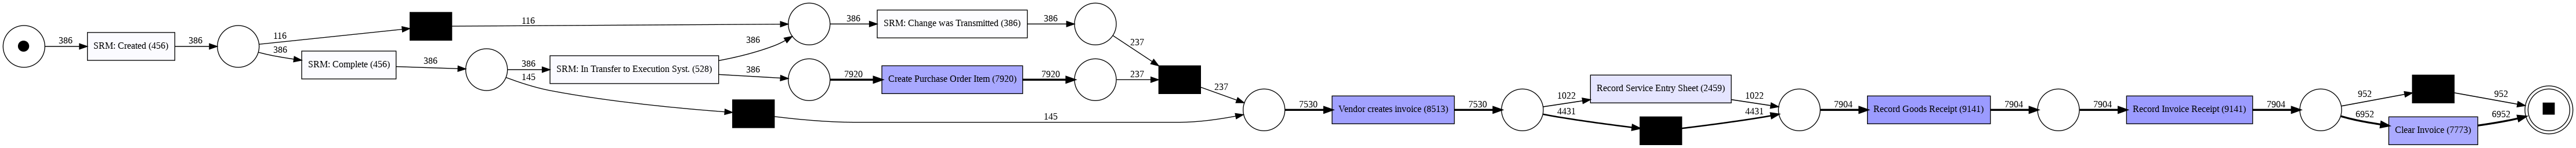

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 64.28571428571429, 'average_trace_fitness': 0.9277864992150703, 'log_fitness': 0.9258586020486966, 'percentage_of_fitting_traces': 64.28571428571429}


replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

Precision:  0.6344086021505376


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

Generalization:  0.7516950313482589
Simplicity:  0.7777777777777779


0.737180314505272

In [98]:
net,im,fm = petri_from_heu(filtered_log_SRM, 0.5, 0, 0)
visualize_petri_heu(event_log, net, im, fm) #### event_log
test(filtered_log_SRM, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/929 [00:00<?, ?it/s]

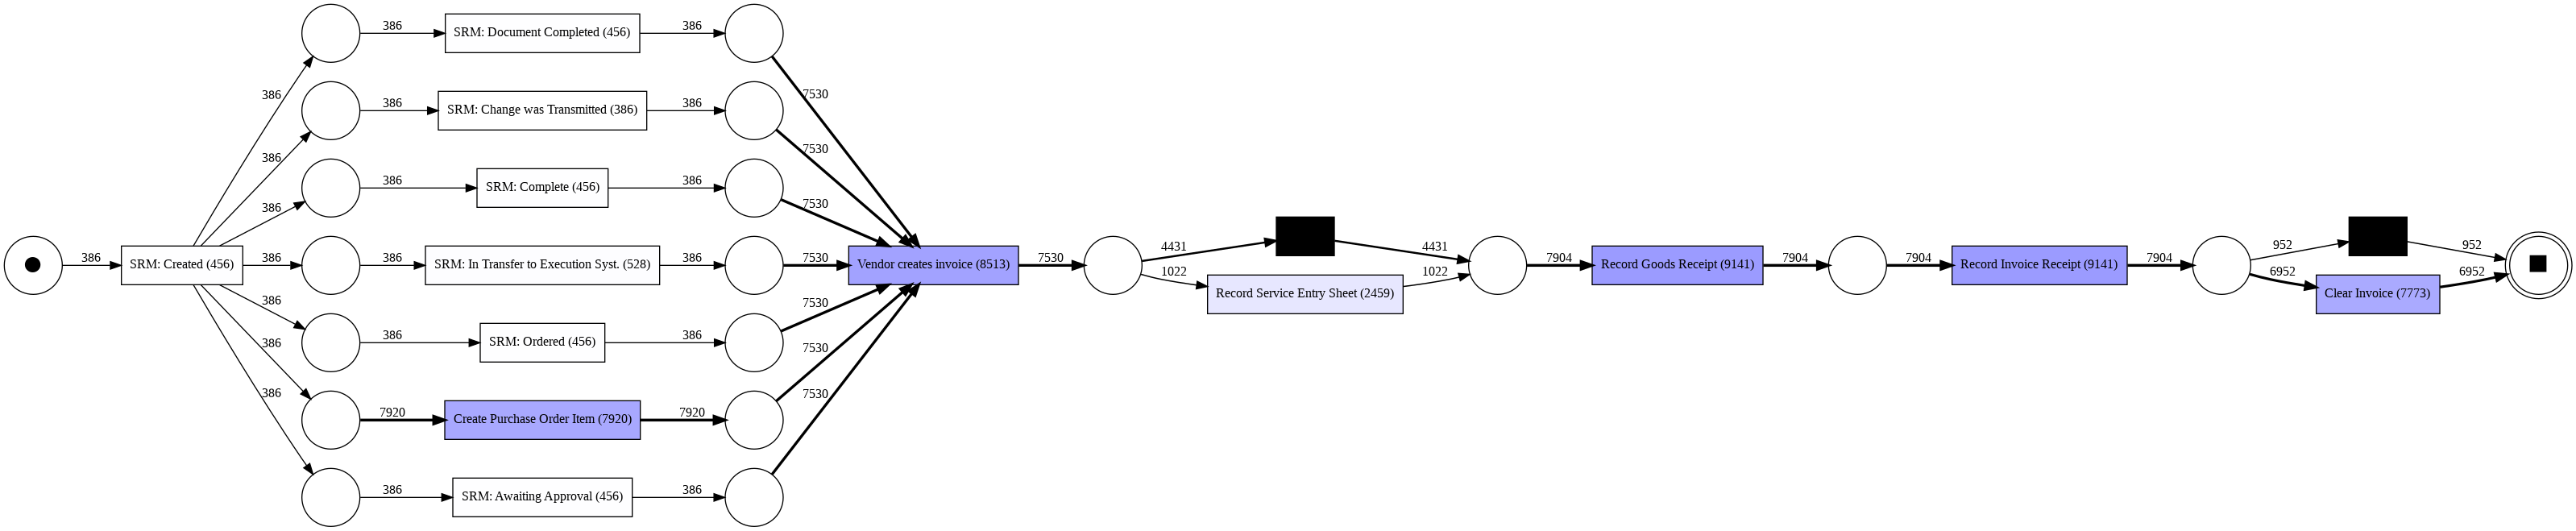

(places: [ p_10, p_11, p_12, p_13, p_14, p_15, p_16, p_17, p_18, p_19, p_20, p_21, p_22, p_5, p_6, p_7, p_8, p_9, sink, source ]
 transitions: [ (0d7c5b83-15a0-4cb3-bf65-7fc8f9107668, 'Create Purchase Order Item'), (2d282394-39b9-4b8d-aa91-359efbd5b324, 'SRM: Change was Transmitted'), (4e8cfadc-f2b1-44b7-afd0-1addd5fd0580, 'Vendor creates invoice'), (51c245f9-b43d-4dda-ab8a-af906b8880d3, 'Record Goods Receipt'), (530d02c7-631e-49db-a21b-873df52a0e31, 'SRM: Awaiting Approval'), (5c26b735-e80e-407b-8c09-4576c139e02a, 'SRM: In Transfer to Execution Syst.'), (689c15e9-652b-4607-aade-cd2c86db9107, 'SRM: Created'), (6ea9b625-6bc1-4739-bab3-1e4dfde2c57e, 'SRM: Complete'), (95e9586f-85ab-42e9-bac3-33f0e7e4866a, 'SRM: Ordered'), (af331f44-1b8d-45d4-b447-502da81820e3, 'Record Service Entry Sheet'), (c6cc0c26-1945-4b67-bfff-2ce3d519dd0b, 'Clear Invoice'), (ef2fcbb7-e486-47dd-b5f4-ce12a96ce4c6, 'SRM: Document Completed'), (fa8490d8-8387-4506-b8ed-3ff08bdfe476, 'Record Invoice Receipt'), (skip_3, N

In [99]:
petri_from_pt(tree, event_log)

Find best Process Tree

# noSRM


In [100]:
filtered_log_noSRM = filter_log_frequency(event_log_noSRM, log_noSRM)

0.48479493891797554


In [101]:
log_noSRM['variant'].value_counts()

Create Purchase Order Item,Vendor creates invoice,Record Goods Receipt,Record Invoice Receipt,Clear Invoice                                     11180
Create Purchase Order Item,Record Goods Receipt,Vendor creates invoice,Record Invoice Receipt,Clear Invoice                                      6495
Create Purchase Order Item,Vendor creates invoice,Record Goods Receipt,Record Invoice Receipt,Remove Payment Block,Clear Invoice                 2964
Create Purchase Order Item,Record Goods Receipt,Vendor creates invoice,Record Invoice Receipt,Remove Payment Block,Clear Invoice                 1584
Create Purchase Requisition Item,Create Purchase Order Item,Vendor creates invoice,Record Goods Receipt,Record Invoice Receipt,Clear Invoice     1068
                                                                                                                                                ...  
Vendor creates invoice,Create Purchase Order Item,Record Goods Receipt,Record Service Entry Sheet,Re

In [102]:
x = log_noSRM['event:user'].value_counts()[0]/log_noSRM['event:user'].count()
print(x)

0.21985165794066316


In [103]:
score_inductive_noSRM = get_best_pt_from_inductive(filtered_log_noSRM)
#im_score:  [[0.9542508915732537]]
#imf_score:  [[0.0, 0.9542508915732537]]
#imd_score:  [[0.0, 0.9542508915732537]]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 12.261106974435343, 'average_trace_fitness': 0.8746587242491508, 'log_fitness': 0.8768163919573475, 'percentage_of_fitting_traces': 12.261106974435343}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9473406842873359


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9793726606518393
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706
im_score:  [[0.9542508915732537]]
imf_score:  [[0.0, 0.9542508915732537]]
imd_score:  [[0.0, 0.9542508915732537]]


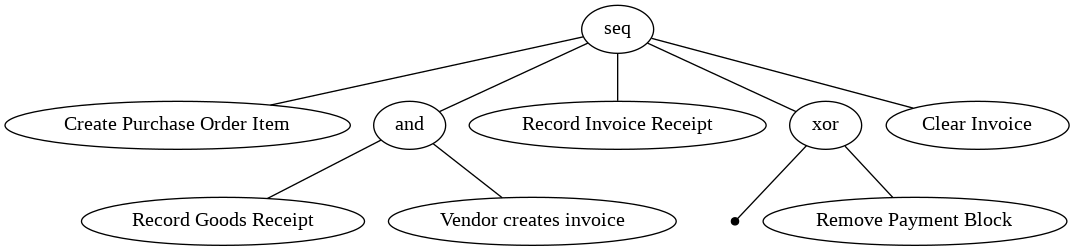

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


0.9542508915732537

In [106]:
net, im, fm, tree = pt_from_inductive_im(filtered_log_noSRM)
visualize_pt(tree)
#to_bpmn(tree, "filtered_log_noSRM.bpmn")
test(filtered_log_noSRM, net, im, fm)

In [107]:
log_noSRM['concept:name'].count()

45840

In [108]:
score_petri_noSRM = get_best_petri(filtered_log_noSRM) # [[0.5, 0, 600, 3.984245618195524]]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9641763878546548, 'log_fitness': 0.9641763878547199, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9677587490692773, 'log_fitness': 0.967758749069248, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.8715180426453532
Simplicity:  0.7599999999999999


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9596984363365599, 'log_fitness': 0.9596984363365599, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9641763878546548, 'log_fitness': 0.9641763878547199, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9677587490692773, 'log_fitness': 0.967758749069248, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.8715180426453532
Simplicity:  0.7599999999999999


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9596984363365599, 'log_fitness': 0.9596984363365599, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9596984363365599, 'log_fitness': 0.9596984363365599, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9596984363365599, 'log_fitness': 0.9596984363365599, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 67.75874906924795, 'average_trace_fitness': 0.9596984363365599, 'log_fitness': 0.9596984363365599, 'percentage_of_fitting_traces': 67.75874906924795}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  0.8666666666666667


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  0.9547339443147367


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9799166808018077
Simplicity:  0.8823529411764706


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Generalization:  0.9842456181955241
Simplicity:  1.0
[[0.5, 0, 600, 0.996061404548881]]


replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

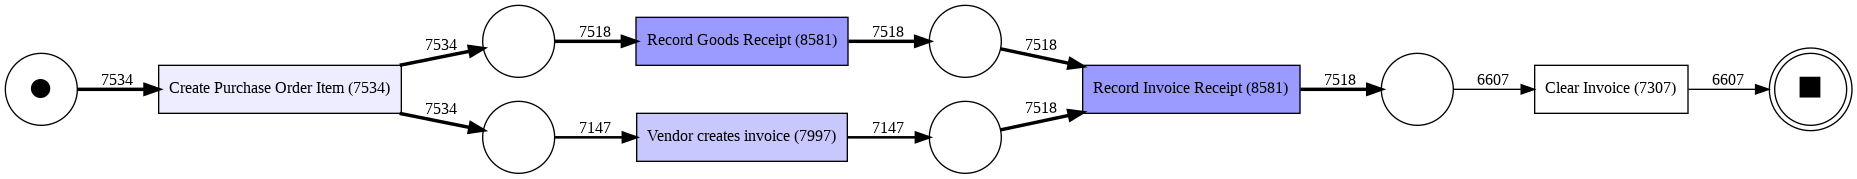

replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 81.78922219272631, 'average_trace_fitness': 0.9554319617984725, 'log_fitness': 0.9431414776107194, 'percentage_of_fitting_traces': 81.78922219272631}


replaying log with TBR, completed variants ::   0%|          | 0/5246 [00:00<?, ?it/s]

Precision:  0.9898366456816031


replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

Generalization:  0.988801543496981
Simplicity:  1.0


0.9655569149986284

In [109]:
net, im, fm = petri_from_heu(filtered_log_noSRM, 0.5, 0, 600)
visualize_petri_heu(event_log_noSRM, net, im, fm) 
test(event_log_noSRM, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

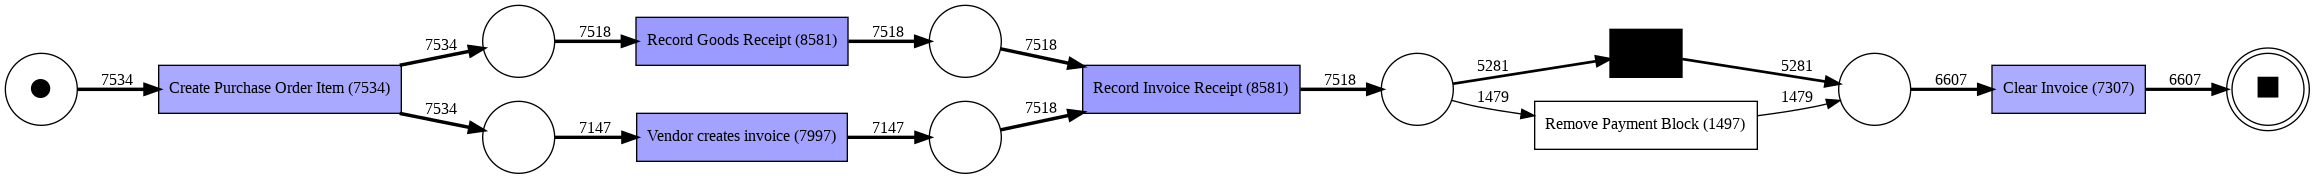

(places: [ p_10, p_5, p_6, p_7, p_8, p_9, sink, source ]
 transitions: [ (3cb10ee0-27c4-43ef-8eeb-6f14a108b128, 'Vendor creates invoice'), (5be73d26-bd1c-45b8-acf7-f801b5247247, 'Record Invoice Receipt'), (6983f95e-badf-4da9-b949-90bdd492b65b, 'Record Goods Receipt'), (72396e32-1b7a-4f3f-b978-108ad9d4b802, 'Clear Invoice'), (90e00b36-2750-4cbb-ac34-a177aa834fad, 'Create Purchase Order Item'), (e3940200-152a-49b9-bb51-535423be8cca, 'Remove Payment Block'), (skip_3, None) ]
 arcs: [ (3cb10ee0-27c4-43ef-8eeb-6f14a108b128, 'Vendor creates invoice')->p_8, (5be73d26-bd1c-45b8-acf7-f801b5247247, 'Record Invoice Receipt')->p_9, (6983f95e-badf-4da9-b949-90bdd492b65b, 'Record Goods Receipt')->p_6, (72396e32-1b7a-4f3f-b978-108ad9d4b802, 'Clear Invoice')->sink, (90e00b36-2750-4cbb-ac34-a177aa834fad, 'Create Purchase Order Item')->p_5, (90e00b36-2750-4cbb-ac34-a177aa834fad, 'Create Purchase Order Item')->p_7, (e3940200-152a-49b9-bb51-535423be8cca, 'Remove Payment Block')->p_10, (skip_3, None)->p_10

In [110]:
petri_from_pt(tree, event_log_noSRM)

In [111]:
calc_share_batch_user(log_noSRM)

batch:  0.08926701570680629 user:  0.6908813263525305 none:  0.21985165794066316


(0.08926701570680629, 0.6908813263525305, 0.21985165794066316)

In [112]:
log_noSRM['case:concept:name'].count()

45840